# import

In [ ]:
import numpy as np
import random
import os
import math
import matplotlib.pyplot as plt

from glob import glob
import pandas as pd
import cv2
from PIL import Image
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

import torchvision.models as models
from torchvision import transforms

import warnings
warnings.filterwarnings('ignore')

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
from albumentations.pytorch.transforms import ToTensor
from albumentations import (
    HorizontalFlip, VerticalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine, 
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose, Normalize, Cutout, ShiftScaleRotate, CenterCrop, Resize, IAAAffine
)

In [ ]:
CFG = {
    'IMG_SIZE':256,
    'EPOCHS':50,
    'LEARNING_RATE':1e-3,
    'BATCH_SIZE':16,
    'SEED':41
}

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED']) # Seed 고정

In [ ]:
def get_train_data(data_dir):
    img_path_list = []
    csv_path_list = []
    label_list = []
    names = []
    for case_name in os.listdir(data_dir):
        current_path = os.path.join(data_dir, case_name)
        case = []
        if os.path.isdir(current_path):
            # get image path
            img_path_list.extend(glob(os.path.join(current_path, 'image', '*.jpg')))
            img_path_list.extend(glob(os.path.join(current_path, 'image', '*.png')))
            # csv image path
            csv_path_list.extend(glob(os.path.join(current_path, 'meta', '*.csv')))
            
            # get label
            label_df = pd.read_csv(current_path+'/label.csv')
            label_list.extend(label_df['leaf_weight'])
            names.extend(label_df['img_name'].map(lambda x: x[:6]))

    return img_path_list, label_list, csv_path_list, names

def get_test_data(data_dir):
    # get image path
    img_path_list = glob(os.path.join(data_dir, 'image', '*.jpg'))
    img_path_list.extend(glob(os.path.join(data_dir, 'image', '*.png')))
    img_path_list.sort(key=lambda x:int(x.split('/')[-1].split('.')[0]))
    return img_path_list

In [ ]:
all_img_path, all_label, all_csv_path, names = get_train_data('/content/drive/MyDrive/dataset/train')
test_img_path = get_test_data('/content/drive/MyDrive/dataset/test')

In [ ]:
lier = ['CASE01_02', 'CASE01_03', "CASE01_04", "CASE01_05", "CASE01_09", "CASE02_08", "CASE04_11", "CASE04_13", "CASE04_21", "CASE04_25", 
        "CASE05_01", "CASE05_07", "CASE05_08", "CASE05_09", "CASE05_10", "CASE05_14", "CASE05_15", "CASE05_18", "CASE05_19", "CASE05_22",
        "CASE06_02", "CASE07_02", "CASE07_04", "CASE09_02", "CASE09_06", "CASE09_07", "CASE10_01", "CASE10_03", "CASE10_05", "CASE10_10",
        "CASE10_22", "CASE10_24", "CASE10_25", "CASE10_36", "CASE10_39", "CASE11_03", "CASE11_05", "CASE11_38", "CASE11_40", "CASE13_08",
        "CASE14_02", "CASE14_03", "CASE14_40", "CASE14_41", "CASE15_09", "CASE18_02", "CASE20_01", "CASE21_02", "CASE22_01", "CASE23_01",
        "CASE23_05", "CASE23_09", "CASE24_04", "CASE24_08", "CASE25_03", "CASE26_01", "CASE26_40", "CASE26_47", "CASE28_01", "CASE29_04",
        "CASE30_08", "CASE30_11", "CASE31_03", "CASE31_09", "CASE32_04", "CASE32_05", "CASE32_07", "CASE32_09", "CASE32_10", "CASE32_14",
        "CASE32_15", "CASE32_20", "CASE32_22", "CASE32_25", "CASE33_02", "CASE33_03", "CASE33_09", "CASE33_11", "CASE33_14", "CASE33_15",
        "CASE33_22", "CASE33_24", "CASE33_25", "CASE34_01", "CASE34_04", "CASE34_06", "CASE34_09", "CASE34_13", "CASE34_14", "CASE34_22",
        "CASE34_23", "CASE34_24", "CASE34_26", "CASE35_10", "CASE35_11", "CASE35_12", "CASE35_18", "CASE35_20", "CASE35_21", "CASE35_22",
        "CASE35_24", "CASE36_01", "CASE36_03", "CASE36_05", "CASE36_06", "CASE36_09", "CASE36_13", "CASE36_16", "CASE36_18", "CASE36_22",
        "CASE36_23", "CASE36_25", "CASE36_26", "CASE36_27", "CASE37_02", "CASE37_04", "CASE37_06", "CASE37_09", "CASE37_10", "CASE37_12",
        "CASE37_14", "CASE37_17", "CASE37_20", "CASE37_22", "CASE37_23", "CASE37_24", "CASE37_26", "CASE38_11", "CASE38_20", "CASE38_22",
        "CASE38_28", "CASE39_01", "CASE39_03", "CASE39_08", "CASE39_12", "CASE39_19", "CASE39_21", "CASE39_23", "CASE39_25", "CASE39_27",
        "CASE40_01", "CASE40_02", "CASE40_07", "CASE40_15", "CASE40_18", "CASE40_22", "CASE40_24", "CASE40_26", "CASE40_27", "CASE41_03",
        "CASE41_04", "CASE41_05", "CASE41_08", "CASE41_13", "CASE41_16", "CASE41_17", "CASE41_23", "CASE41_25", "CASE42_02", "CASE42_03",
        "CASE42_05", "CASE42_07", "CASE42_15", "CASE42_17", "CASE42_24", "CASE43_03", "CASE43_15", "CASE43_26", "CASE44_04", "CASE44_06",
        "CASE44_08", "CASE44_09", "CASE44_13", "CASE44_15", "CASE44_18", "CASE44_20", "CASE44_24", "CASE44_26", "CASE44_27", "CASE45_01",
        "CASE45_02", "CASE45_03", "CASE45_06", "CASE45_08", "CASE45_09", "CASE45_15", "CASE45_17", "CASE45_22", "CASE45_23", "CASE47_02",
        "CASE50_02", "CASE50_14", "CASE50_25", "CASE51_02", "CASE51_05", "CASE51_17", "CASE51_23", "CASE51_26", "CASE52_02", "CASE52_08",
        "CASE52_11", "CASE52_16", "CASE52_22", "CASE52_26", "CASE53_01", "CASE53_07", "CASE53_08", "CASE53_09", "CASE53_16", "CASE53_26",
        "CASE54_01", "CASE54_06", "CASE55_03", "CASE55_11", "CASE55_12", "CASE55_18", "CASE55_25", "CASE57_03", "CASE57_21", "CASE57_23",
        "CASE58_01", "CASE58_02", "CASE58_04", "CASE58_06", "CASE58_27", "CASE58_32", "CASE59_02", "CASE59_04", "CASE59_05", "CASE59_07",
        "CASE59_08", "CASE59_11", "CASE59_24", "CASE59_27", "CASE60_11", "CASE60_13", "CASE60_20", "CASE61_02", "CASE61_03", "CASE61_07",
        "CASE61_24", "CASE61_25", "CASE62_17", "CASE62_19", "CASE63_02", "CASE63_05", "CASE63_10", "CASE63_11", "CASE63_20", "CASE63_21",
        "CASE63_23", "CASE64_04", "CASE64_08", "CASE64_12", "CASE64_20", "CASE64_23", "CASE67_03", "CASE67_04", "CASE67_08", "CASE67_09",
        "CASE67_24", "CASE67_25", "CASE67_26", "CASE68_01", "CASE68_02", "CASE68_12", "CASE68_13", "CASE68_16", "CASE68_27", "CASE69_07",
        "CASE69_15", "CASE70_16", "CASE70_21", "CASE71_08", "CASE71_23", "CASE73_05", "CASE73_18", "CASE73_23", "CASE74_01", "CASE74_05",
        "CASE74_08", "CASE74_09", "CASE74_10", "CASE74_17"]
    
def removecase(x):
    for i in lier:
        if i in x:
            return False
    return True

df = pd.DataFrame({"path": all_img_path, "label": all_label})
df = df[df['path'].map(lambda x: removecase(x))]

In [ ]:
# plt.imshow(cv2.imread(all_img_path[660]))

# 이상치 확인 및 제거

In [ ]:
len(os.listdir('/content/drive/MyDrive/dataset/train'))

75

In [ ]:
len(all_img_path)

1592

In [ ]:
df = pd.DataFrame({"path": all_img_path, "label": all_label})

In [ ]:
def caseimage(c):
  d = df[df['path'].str.contains(c)].sort_values(by='path')
  plt.figure(figsize=(16,10))
  for i in range(len(d)):
    plt.subplot(len(d)//5 + 1, 5, i+1)
    plt.imshow(cv2.imread(d.iloc[i]['path']))
    plt.title(d.iloc[i]['path'][-9:] + '__' + str(d.iloc[i]['label']))
  plt.subplots_adjust(left=0.125,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0.35)
  plt.show()

def caseplot(c):
  d = df[df['path'].str.contains(c)].sort_values(by='path')
  plt.plot(d['label'].values)

def weightimage(w):
  def clip(x):
    if x < w + 3 and x > w - 3:
      return True
    else:
      return False
  d = df[df['label'].map(lambda x: clip(x))]
  plt.figure(figsize=(16,10))
  count = min(len(d), 10)
  for i in range(count):
    plt.subplot(2, 5, i+1)
    plt.imshow(cv2.imread(d.iloc[i]['path']))
    plt.title(d.iloc[i]['path'][-9:] + '__' + str(d.iloc[i]['label']))
  plt.show()

In [ ]:
case = "CASE75"
caseplot(case)

In [ ]:
caseimage(case)

<Figure size 1152x720 with 0 Axes>

In [ ]:
weightimage(173)

In [ ]:
lier = ['CASE01_02', 'CASE01_03', "CASE01_04", "CASE01_05", "CASE01_09", "CASE02_08", "CASE04_11", "CASE04_13", "CASE04_21", "CASE04_25", 
        "CASE05_01", "CASE05_07", "CASE05_08", "CASE05_09", "CASE05_10", "CASE05_14", "CASE05_15", "CASE05_18", "CASE05_19", "CASE05_22",
        "CASE06_02", "CASE07_02", "CASE07_04", "CASE09_02", "CASE09_06", "CASE09_07", "CASE10_01", "CASE10_03", "CASE10_05", "CASE10_10",
        "CASE10_22", "CASE10_24", "CASE10_25", "CASE10_36", "CASE10_39", "CASE11_03", "CASE11_05", "CASE11_38", "CASE11_40", "CASE13_08",
        "CASE14_02", "CASE14_03", "CASE14_40", "CASE14_41", "CASE15_09", "CASE18_02", "CASE20_01", "CASE21_02", "CASE22_01", "CASE23_01",
        "CASE23_05", "CASE23_09", "CASE24_04", "CASE24_08", "CASE25_03", "CASE26_01", "CASE26_40", "CASE26_47", "CASE28_01", "CASE29_04",
        "CASE30_08", "CASE30_11", "CASE31_03", "CASE31_09", "CASE32_04", "CASE32_05", "CASE32_07", "CASE32_09", "CASE32_10", "CASE32_14",
        "CASE32_15", "CASE32_20", "CASE32_22", "CASE32_25", "CASE33_02", "CASE33_03", "CASE33_09", "CASE33_11", "CASE33_14", "CASE33_15",
        "CASE33_22", "CASE33_24", "CASE33_25", "CASE34_01", "CASE34_04", "CASE34_06", "CASE34_09", "CASE34_13", "CASE34_14", "CASE34_22",
        "CASE34_23", "CASE34_24", "CASE34_26", "CASE35_10", "CASE35_11", "CASE35_12", "CASE35_18", "CASE35_20", "CASE35_21", "CASE35_22",
        "CASE35_24", "CASE36_01", "CASE36_03", "CASE36_05", "CASE36_06", "CASE36_09", "CASE36_13", "CASE36_16", "CASE36_18", "CASE36_22",
        "CASE36_23", "CASE36_25", "CASE36_26", "CASE36_27", "CASE37_02", "CASE37_04", "CASE37_06", "CASE37_09", "CASE37_10", "CASE37_12",
        "CASE37_14", "CASE37_17", "CASE37_20", "CASE37_22", "CASE37_23", "CASE37_24", "CASE37_26", "CASE38_11", "CASE38_20", "CASE38_22",
        "CASE38_28", "CASE39_01", "CASE39_03", "CASE39_08", "CASE39_12", "CASE39_19", "CASE39_21", "CASE39_23", "CASE39_25", "CASE39_27",
        "CASE40_01", "CASE40_02", "CASE40_07", "CASE40_15", "CASE40_18", "CASE40_22", "CASE40_24", "CASE40_26", "CASE40_27", "CASE41_03",
        "CASE41_04", "CASE41_05", "CASE41_08", "CASE41_13", "CASE41_16", "CASE41_17", "CASE41_23", "CASE41_25", "CASE42_02", "CASE42_03",
        "CASE42_05", "CASE42_07", "CASE42_15", "CASE42_17", "CASE42_24", "CASE43_03", "CASE43_15", "CASE43_26", "CASE44_04", "CASE44_06",
        "CASE44_08", "CASE44_09", "CASE44_13", "CASE44_15", "CASE44_18", "CASE44_20", "CASE44_24", "CASE44_26", "CASE44_27", "CASE45_01",
        "CASE45_02", "CASE45_03", "CASE45_06", "CASE45_08", "CASE45_09", "CASE45_15", "CASE45_17", "CASE45_22", "CASE45_23", "CASE47_02",
        "CASE50_02", "CASE50_14", "CASE50_25", "CASE51_02", "CASE51_05", "CASE51_17", "CASE51_23", "CASE51_26", "CASE52_02", "CASE52_08",
        "CASE52_11", "CASE52_16", "CASE52_22", "CASE52_26", "CASE53_01", "CASE53_07", "CASE53_08", "CASE53_09", "CASE53_16", "CASE53_26",
        "CASE54_01", "CASE54_06", "CASE55_03", "CASE55_11", "CASE55_12", "CASE55_18", "CASE55_25", "CASE57_03", "CASE57_21", "CASE57_23",
        "CASE58_01", "CASE58_02", "CASE58_04", "CASE58_06", "CASE58_27", "CASE58_32", "CASE59_02", "CASE59_04", "CASE59_05", "CASE59_07",
        "CASE59_08", "CASE59_11", "CASE59_24", "CASE59_27", "CASE60_11", "CASE60_13", "CASE60_20", "CASE61_02", "CASE61_03", "CASE61_07",
        "CASE61_24", "CASE61_25", "CASE62_17", "CASE62_19", "CASE63_02", "CASE63_05", "CASE63_10", "CASE63_11", "CASE63_20", "CASE63_21",
        "CASE63_23", "CASE64_04", "CASE64_08", "CASE64_12", "CASE64_20", "CASE64_23", "CASE67_03", "CASE67_04", "CASE67_08", "CASE67_09",
        "CASE67_24", "CASE67_25", "CASE67_26", "CASE68_01", "CASE68_02", "CASE68_12", "CASE68_13", "CASE68_16", "CASE68_27", "CASE69_07",
        "CASE69_15", "CASE70_16", "CASE70_21", "CASE71_08", "CASE71_23", "CASE73_05", "CASE73_18", "CASE73_23", "CASE74_01", "CASE74_05",
        "CASE74_08", "CASE74_09", "CASE74_10", "CASE74_17"]
idx = [i for i in range(len(all_img_path)) for j in lier if j in all_img_path[i]]

In [ ]:
li = []
for i in all_label:
  li.append(round(i))

In [ ]:
for i in idx:
  del all_img_path[i]
  del all_label[i]

# 데이터 확인

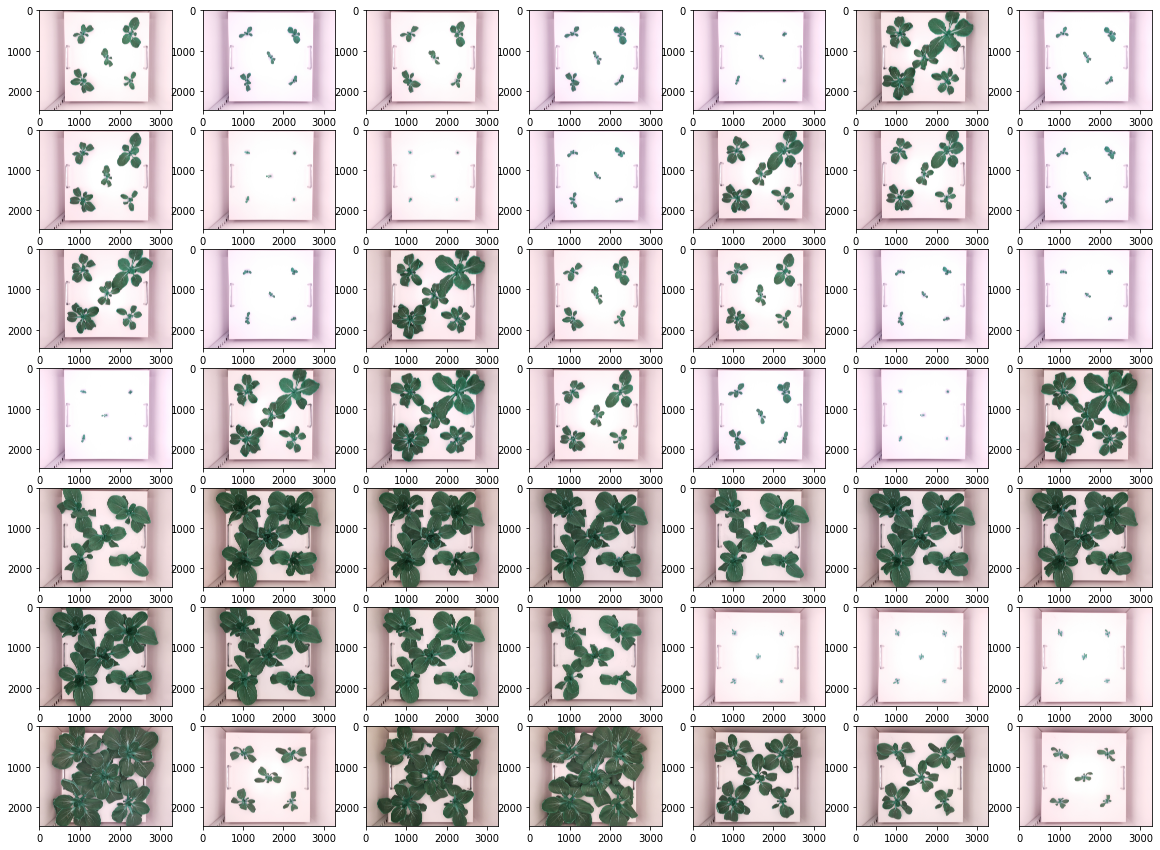

In [ ]:
plt.figure(figsize=(20,15))
for i in range(49):
  plt.subplot(7,7,i+1)
  plt.imshow(cv2.imread(all_img_path[i]))
plt.show()

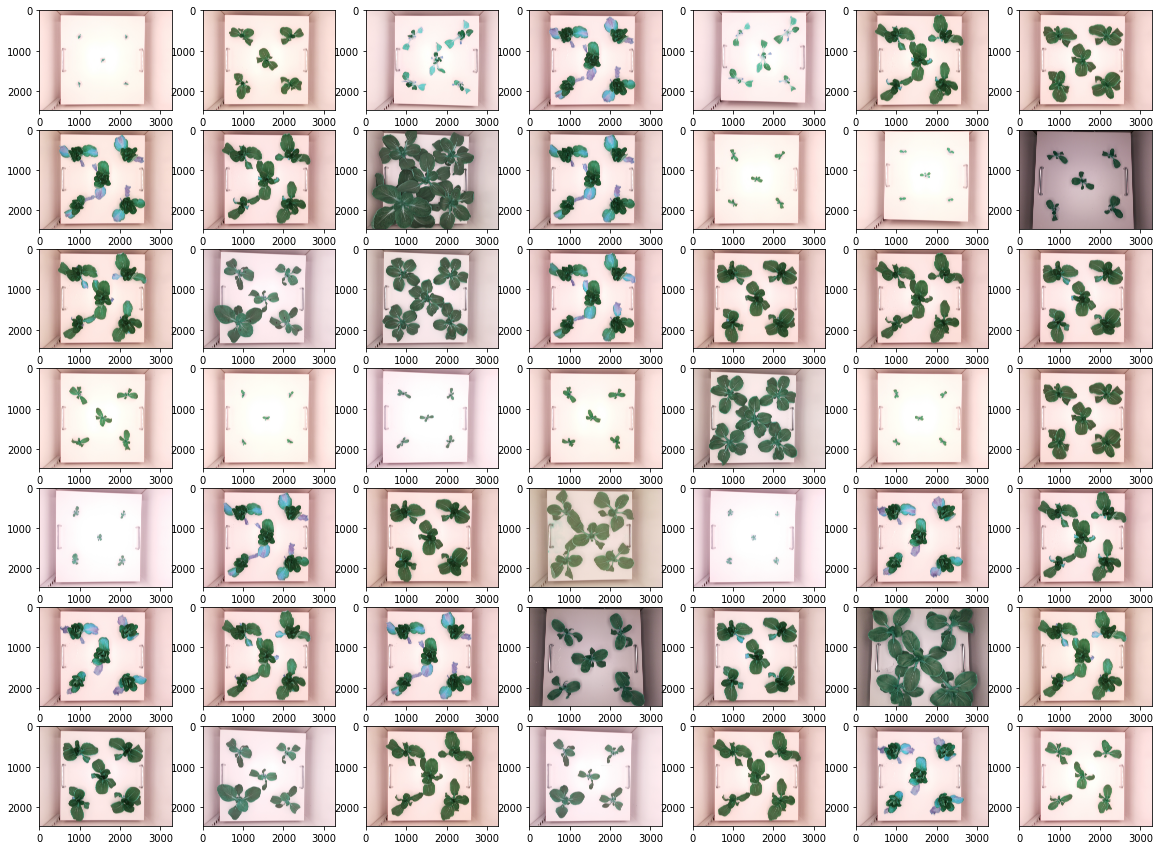

In [ ]:
plt.figure(figsize=(20,15))
for i in range(49):
  plt.subplot(7,7,i+1)
  plt.imshow(cv2.imread(test_img_path[i+10]))
plt.show()

In [ ]:
fea = []
for label, csv in zip(all_label, all_csv_path):
 vals = np.append(pd.read_csv(csv).mean().values, label)
 fea.append(vals)
idx = list(np.append(pd.read_csv(csv).mean().index, 'label'))

data = pd.DataFrame(fea, columns=idx)

In [ ]:
len(data[data['내부온도관측치'].isnull()])

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(15,10))
sns.heatmap(data.corr())

In [ ]:
data.corr()

# Train

In [ ]:
# # Train : Validation = 0.8 : 0.2 Split
# train_len = int(len(all_img_path)*0.8)

# train_img_path = all_img_path[:train_len]
# train_label = all_label[:train_len]

# vali_img_path = all_img_path[train_len:]
# vali_label = all_label[train_len:]

In [ ]:
# cri = []
# for i in all_label:
#   if i >= 400:
#     x = 400
#   else:
#     x = round(i, -1)
#   cri.append(x)

In [ ]:
# from sklearn.model_selection import train_test_split

# train_img_path, vali_img_path, train_label, vali_label = train_test_split(all_img_path, all_label, test_size=0.2, shuffle=True, stratify=cri, random_state=41)

In [ ]:
from sklearn.model_selection import train_test_split

train_img_path, vali_img_path, train_label, vali_label = train_test_split(df['path'].values, df['label'].values, test_size=0.2, shuffle=True, random_state=0)

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, img_path_list, label_list, train_mode=True, transforms=None):
        self.transforms = transforms
        self.train_mode = train_mode
        self.img_path_list = img_path_list
        self.label_list = label_list

    def __getitem__(self, index):
        img_path = self.img_path_list[index]
        # Get image data
        image = Image.open(img_path).convert('RGB')
        if self.transforms is not None:
            image = self.transforms(image)

        # image = cv2.imread(img_path)
        # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.uint8) 
        # if self.transforms is not None:
        #     image = self.transforms(image=image)['image'] 

        if self.train_mode:
            label = self.label_list[index]
            # label += np.random.randn(1)
            return image, label
        else:
            return image
    
    def __len__(self):
        return len(self.img_path_list)

In [ ]:
train_transform = transforms.Compose([
                    transforms.Resize((CFG['IMG_SIZE'], CFG['IMG_SIZE'])),
                    transforms.RandomApply([transforms.RandomResizedCrop(CFG['IMG_SIZE'], scale=(0.8,1))], p=0.5),
                    # transforms.RandomApply([transforms.RandomAffine(0, shear=1)], p=0.5),
                    transforms.RandomApply([transforms.ColorJitter(0.1)], p=0.5),
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
                    ])

test_transform = transforms.Compose([
                    transforms.Resize((CFG['IMG_SIZE'], CFG['IMG_SIZE'])),
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
                    ])

In [ ]:
# train_transform = Compose([
#                   Transpose(p=0.5),
#                   HorizontalFlip(p=0.5),
#                   VerticalFlip(p=0.5),
#                   ShiftScaleRotate(shift_limit=0, scale_limit=(0, 0.2), rotate_limit=0, interpolation=0, border_mode=0, p=0.5),
#                   RandomBrightnessContrast(brightness_limit=(-0.1,0.1), contrast_limit=(-0.1, 0.1), p=0.5),
#                   Resize(CFG['IMG_SIZE'], CFG['IMG_SIZE']),
#                   Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
#                   ToTensor(),
#                   ], p=1.)
# test_transform = Compose([
#                   Resize(CFG['IMG_SIZE'], CFG['IMG_SIZE']),
#                   Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
#                   ToTensor(),
#                   ], p=1.) 

In [ ]:
# Get Dataloader
train_dataset = CustomDataset(train_img_path, train_label, train_mode=True, transforms=train_transform)
train_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=True, num_workers=4)

vali_dataset = CustomDataset(vali_img_path, vali_label, train_mode=True, transforms=test_transform)
vali_loader = DataLoader(vali_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=4)

In [ ]:
# for i in train_loader:
#   s = 1
#   plt.figure(figsize=(16,10))
#   for img in i[0]:
#     plt.subplot(4,4,s)
#     plt.imshow(np.transpose(img, (1,2,0)))
#     s = s + 1
#   break

In [ ]:
# test_dataset = CustomDataset(test_img_path, None, train_mode=False, transforms=test_transform)
# test_loader = DataLoader(test_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=4)

# for i in test_loader:
#   s = 1
#   plt.figure(figsize=(16,10))
#   for img in i:
#     plt.subplot(4,4,s)
#     plt.imshow(np.transpose(img, (1,2,0)))
#     s = s + 1
#   break

In [ ]:
class CNNRegressor(torch.nn.Module):
    def __init__(self):
        super(CNNRegressor, self).__init__()
        self.layer1 = self.conv(3, 64)
        self.layer2 = self.conv(64, 64)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.layer3 = self.conv(64, 128)
        self.layer4 = self.conv(128, 128)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.layer5 = self.conv(128, 256)
        self.layer6 = self.conv(256, 256)
        self.maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.layer7 = self.conv(256, 512)
        self.layer8 = self.conv(512, 512)
        self.layer9 = self.conv(512, 512)
        self.maxpool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.layer10 = self.conv(512, 512)
        self.layer11 = self.conv(512, 512)
        self.layer12 = self.conv(512, 512)
        self.maxpool5 = nn.MaxPool2d(kernel_size=2, stride=2)
        # self.avg = nn.AdaptiveAvgPool2d(1)
        # self.avg = nn.AvgPool2d(4)
        
        self.regressor = nn.Sequential(
          nn.Linear(8*8*512, 100),
          nn.LeakyReLU(),
          nn.Linear(100, 1)
        )

        #avgpool
        # self.regressor = nn.Sequential(
        #   nn.Linear(1, 1)
        # )

    def conv(self, in_channels, out_channels):
      layer = nn.Sequential(
          nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
          nn.BatchNorm2d(out_channels),
          nn.LeakyReLU(),
      )
      return layer

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.maxpool1(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.maxpool2(x)
        x = self.layer5(x)
        x = self.layer6(x)
        x = self.maxpool3(x)
        x = self.layer7(x)
        x = self.layer8(x)
        x = self.layer9(x)
        x = self.maxpool4(x)
        x = self.layer10(x)
        x = self.layer11(x)
        x = self.layer12(x)
        x = self.maxpool5(x)
        x = torch.flatten(x, start_dim=1)
        # x = self.avg(x)
        out = self.regressor(x)
        return out

def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)
    elif type(m) == nn.Conv2d:
        nn.init.kaiming_uniform_(m.weight, mode='fan_out')

In [ ]:
def train(model, optimizer, train_loader, vali_loader, scheduler, device, epochs, patience=15):
    model.to(device)

    # Loss Function
    criterion = nn.L1Loss().to(device)
    # criterion = nn.MSELoss().to(device)
    best_mae = 99999
    pat = 0
    
    for epoch in range(1, epochs+1):
        model.train()
        train_loss = []
        for img, label in tqdm(iter(train_loader)):
            img, label = img.float().to(device), label.float().to(device)
            
            optimizer.zero_grad()

            # Data -> Model -> Output
            logit = model(img)
            # Calc loss
            loss = criterion(logit.squeeze(1), label)

            # backpropagation
            loss.backward()
            optimizer.step()

            train_loss.append(loss.item())
            
            # if scheduler is not None:
            #     scheduler.step()
            
        # Evaluation Validation set
        vali_mae = validation(model, vali_loader, criterion, device)
        # vali_mae = 0
        if scheduler is not None:
            # scheduler.step(vali_mae)
            scheduler.step()
        print(f'Epoch [{epoch}] Train Loss : [{np.mean(train_loss):.5f}] Validation Loss : [{vali_mae:.5f}]\n')
        pat += 1
        # Model Saved
        if best_mae > vali_mae:
            best_mae = vali_mae
            torch.save(model.state_dict(), '/content/best_model.pth')
            print('Model Saved.')
            pat = 0

        if patience != 0 and pat == patience:
          break

In [ ]:
def validation(model, vali_loader, criterion, device):
    model.eval() # Evaluation
    vali_loss = []
    with torch.no_grad():
        for img, label in tqdm(iter(vali_loader)):
            img, label = img.float().to(device), label.float().to(device)

            logit = model(img)
            loss = criterion(logit.squeeze(1), label)
            
            vali_loss.append(loss.item())

    vali_mae_loss = np.mean(vali_loss)
    return vali_mae_loss

In [ ]:
model = CNNRegressor().to(device)
model.apply(init_weights)

# optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5, weight_decay=1e-3)
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3, betas = (0.9, 0.999))
# scheduler = None
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 5, gamma = 0.7)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.2, patience=5, threshold=1e-3)

train(model, optimizer, train_loader, vali_loader, scheduler, device, 50, 0)

  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [1] Train Loss : [34.04576] Validation Loss : [39.76652]

Model Saved.


  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [2] Train Loss : [33.52718] Validation Loss : [39.48589]

Model Saved.


  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [3] Train Loss : [33.47811] Validation Loss : [39.78509]



  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [4] Train Loss : [33.38953] Validation Loss : [39.57753]



  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [5] Train Loss : [33.52196] Validation Loss : [39.78285]



  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [6] Train Loss : [34.14592] Validation Loss : [39.77779]



  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [7] Train Loss : [33.61641] Validation Loss : [39.63775]



  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [8] Train Loss : [33.16752] Validation Loss : [39.57444]



  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [9] Train Loss : [34.56434] Validation Loss : [39.96393]



  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [10] Train Loss : [33.56987] Validation Loss : [39.77127]



In [ ]:
def predict(model, test_loader, device):
    model.eval()
    model_pred = []
    with torch.no_grad():
        for img in tqdm(iter(test_loader)):
            img = img.float().to(device)

            pred_logit = model(img)
            pred_logit = pred_logit.squeeze(1).detach().cpu()

            model_pred.extend(pred_logit.tolist())
    return model_pred

In [ ]:
test_dataset = CustomDataset(test_img_path, None, train_mode=False, transforms=test_transform)
test_loader = DataLoader(test_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=4)

In [ ]:
preds = predict(model, test_loader, device)
submission = pd.read_csv('/content/drive/MyDrive/dataset/sample_submission.csv')
submission['leaf_weight'] = preds
submission.to_csv('/content/drive/MyDrive/dataset/sub.csv', index=False)

  0%|          | 0/29 [00:00<?, ?it/s]

In [ ]:
# Validation Score가 가장 뛰어난 모델을 불러옵니다.
checkpoint = torch.load('/content/best_model.pth')
model = CNNRegressor().to(device)
model.load_state_dict(checkpoint)

# Inference
preds = predict(model, test_loader, device)

  0%|          | 0/29 [00:00<?, ?it/s]

In [ ]:
submission = pd.read_csv('/content/drive/MyDrive/dataset/sample_submission.csv')
submission['leaf_weight'] = preds
submission.to_csv('/content/drive/MyDrive/dataset/subbest.csv', index=False)